### Molecule solubility prediction with basic GNN model

Water (or any other kind of) solubility is the property of the whole molecule, therefore we will have a simple binary clasification problem for the whole molecule. <br> <br>

### References 
PyG [examples](https://github.com/pyg-team/pytorch_geometric/tree/master/examples) on GNN <br>
Textbook: Deep Learning for the Life Sciences: Applying Deep Learning to Genomics, Microscopy, Drug Discovery, and More

In [ ]:
!python -c "import torch; print(torch.__version__)"
!python -c "import torch; print(torch.version.cuda)"
!python --version

!nvidia-smi

In [ ]:
pytorch_version = f"torch-{torch.__version__}.html"
!pip install --no-index torch-scatter -f https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
!pip install --no-index torch-sparse -f https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
!pip install --no-index torch-cluster -f https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
!pip install --no-index torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
!pip install torch-geometric
!pip -q install rdkit-pypi

In [32]:
import torch
from torch.nn import Linear
import torch.nn.functional as F 
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.data import DataLoader
from torch_geometric.datasets import MoleculeNet

import pandas as pd 
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

import rdkit
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import MolsToGridImage

ESOL [dataset](https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/delaney-processed.csv) will be used

[This dataset is created based on MoleculeNet.org](http://ww82.moleculenet.ai/).

In [6]:
# Load the ESOL dataset
data = MoleculeNet(root=".", name="ESOL")
data

ESOL(1128)

In [7]:
print("Dataset type: ", type(data))
print("Dataset features: ", data.num_features)
print("Dataset target: ", data.num_classes)
print("Dataset length: ", data.len)
print("Dataset sample: ", data[0])
print("Sample  nodes: ", data[0].num_nodes)
print("Sample  edges: ", data[0].num_edges)

Dataset type:  <class 'torch_geometric.datasets.molecule_net.MoleculeNet'>
Dataset features:  9
Dataset target:  734
Dataset length:  <bound method InMemoryDataset.len of ESOL(1128)>
Dataset sample:  Data(x=[32, 9], edge_index=[2, 68], edge_attr=[68, 3], y=[1, 1], smiles='OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O ')
Sample  nodes:  32
Sample  edges:  68


In [ ]:
# Shape of nodes is made of [num_nodes, num_node_features]
data[0].x

tensor([[8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 1],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 0],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 1],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 0],
        [6, 0, 2, 5, 0, 0, 2, 0, 0],
        [7, 0, 1, 5, 0, 0, 2, 0, 0],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
 

In [8]:
# Shape of edges is [2, num_edges]
data[0].edge_index.t()

tensor([[ 0,  1],
        [ 1,  0],
        [ 1,  2],
        [ 2,  1],
        [ 2,  3],
        [ 2, 30],
        [ 3,  2],
        [ 3,  4],
        [ 4,  3],
        [ 4,  5],
        [ 4, 26],
        [ 5,  4],
        [ 5,  6],
        [ 6,  5],
        [ 6,  7],
        [ 7,  6],
        [ 7,  8],
        [ 7, 24],
        [ 8,  7],
        [ 8,  9],
        [ 9,  8],
        [ 9, 10],
        [ 9, 20],
        [10,  9],
        [10, 11],
        [11, 10],
        [11, 12],
        [11, 14],
        [12, 11],
        [12, 13],
        [13, 12],
        [14, 11],
        [14, 15],
        [14, 19],
        [15, 14],
        [15, 16],
        [16, 15],
        [16, 17],
        [17, 16],
        [17, 18],
        [18, 17],
        [18, 19],
        [19, 14],
        [19, 18],
        [20,  9],
        [20, 21],
        [20, 22],
        [21, 20],
        [22, 20],
        [22, 23],
        [22, 24],
        [23, 22],
        [24,  7],
        [24, 22],
        [24, 25],
        [2

In [10]:
data[0].y

tensor([[-0.7700]])

In [11]:
data[150]["smiles"]

'Nc1ncnc2n(ccc12)C3OC(CO)C(O)C3O '

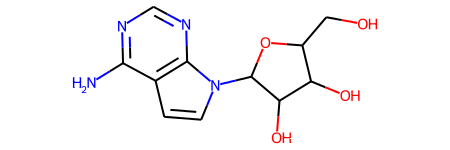

In [12]:
molecule = Chem.MolFromSmiles(data[150]["smiles"])
molecule

In [13]:
type(molecule)

rdkit.Chem.rdchem.Mol

We implement GNN in form of basic GCN and do aggregation only from 4 hop neighbourhood

In [24]:
embedding_size = 64

class GCN(torch.nn.Module):
    def __init__(self):
        # Init parent
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # GCN layers
        self.initial_conv = GCNConv(data.num_features, embedding_size)
        self.conv1 = GCNConv(embedding_size, embedding_size)
        self.conv2 = GCNConv(embedding_size, embedding_size)
        self.conv3 = GCNConv(embedding_size, embedding_size)
        self.conv4 = GCNConv(embedding_size, embedding_size)

        # Output layer
        self.out = Linear(embedding_size*2, 1)

    def forward(self, x, edge_index, batch_index):
        # Starting GCN layer
        hidden = self.initial_conv(x, edge_index)
        hidden = F.tanh(hidden)

        # Other GCN layers 
        hidden = self.conv1(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv2(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv3(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv4(hidden, edge_index)
        hidden = F.tanh(hidden)

        # Global Pooling 
        hidden = torch.cat([gmp(hidden, batch_index), 
                            gap(hidden, batch_index)], dim=1)

        # Linear Layer
        out = self.out(hidden)

        return out, hidden

model = GCN()
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

GCN(
  (initial_conv): GCNConv(9, 64)
  (conv1): GCNConv(64, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (conv4): GCNConv(64, 64)
  (out): Linear(in_features=128, out_features=1, bias=True)
)
Number of parameters:  17409


Training

In [25]:
warnings.filterwarnings("ignore")

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)  

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

data_size = len(data)
NUM_GRAPHS_PER_BATCH = 64
loader = DataLoader(data[:int(data_size * 0.8)], 
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(data[int(data_size * 0.8):], 
                         batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)

def train(data):
    for batch in loader:
      batch.to(device)  
      optimizer.zero_grad() 
      pred, embedding = model(batch.x.float(), batch.edge_index, batch.batch)    
      loss = torch.sqrt(loss_fn(pred, batch.y))       
      loss.backward()  
      optimizer.step()   
    return loss, embedding

print("Starting training...")
losses = []
for epoch in range(2000):
    loss, h = train(data)
    losses.append(loss)
    if epoch % 100 == 0:
      print(f"Epoch {epoch} | Train Loss {loss}")

Starting training...
Epoch 0 | Train Loss 1.3539716005325317
Epoch 100 | Train Loss 1.6366606950759888
Epoch 200 | Train Loss 0.48921650648117065
Epoch 300 | Train Loss 0.8494959473609924
Epoch 400 | Train Loss 0.5579820871353149
Epoch 500 | Train Loss 0.9647320508956909
Epoch 600 | Train Loss 0.5030287504196167
Epoch 700 | Train Loss 0.21864736080169678
Epoch 800 | Train Loss 0.2759800851345062
Epoch 900 | Train Loss 0.2696096897125244
Epoch 1000 | Train Loss 0.9519162774085999
Epoch 1100 | Train Loss 0.16071602702140808
Epoch 1200 | Train Loss 0.11910390853881836
Epoch 1300 | Train Loss 0.45708903670310974
Epoch 1400 | Train Loss 0.11899296194314957
Epoch 1500 | Train Loss 0.15048734843730927
Epoch 1600 | Train Loss 0.11756868660449982
Epoch 1700 | Train Loss 0.11161550134420395
Epoch 1800 | Train Loss 0.22669117152690887
Epoch 1900 | Train Loss 0.1224280521273613


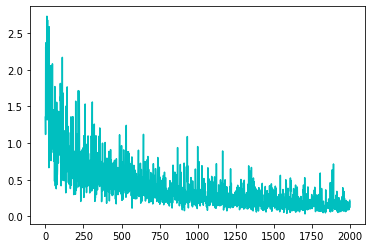

In [30]:
# Plotting training loss
losses_float = [float(loss.cpu().detach().numpy()) for loss in losses] 
indices = [i for i,l in enumerate(losses_float)] 
plt.plot(indices, losses_float, c='c');


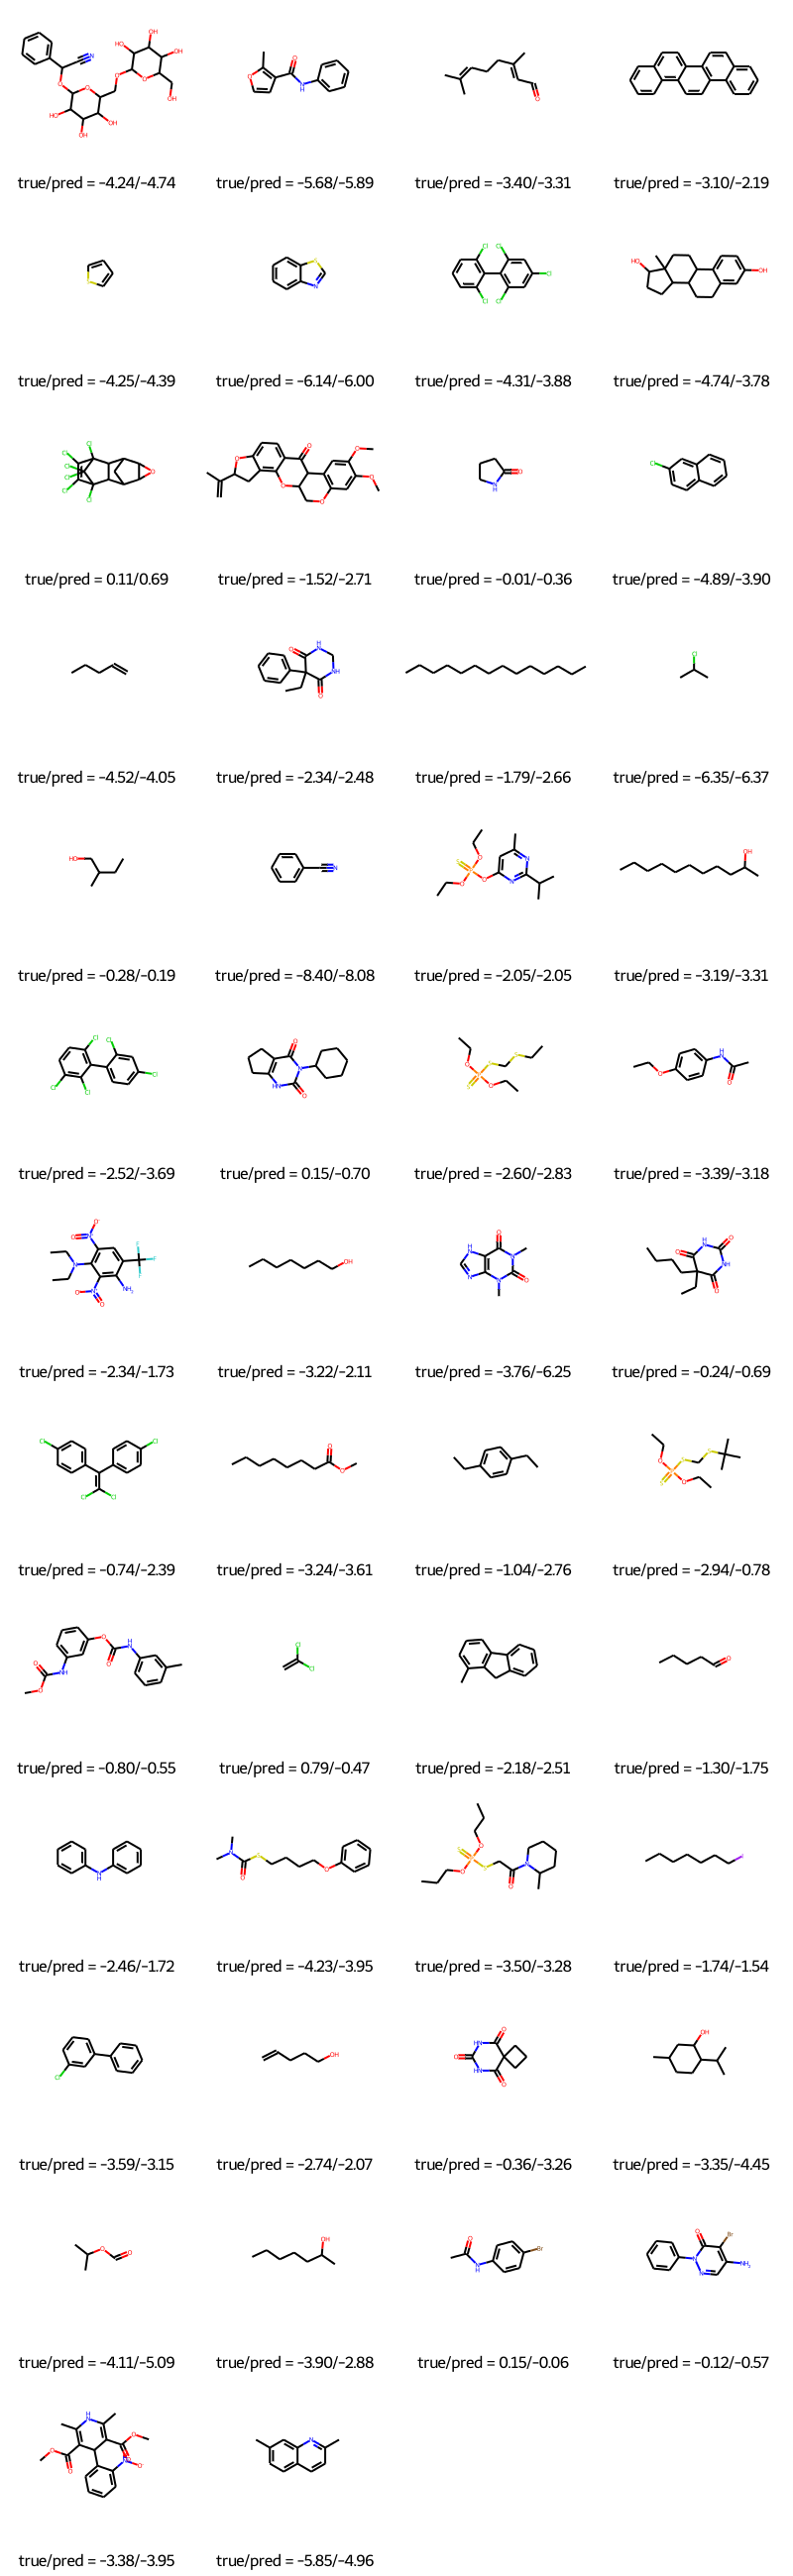

In [44]:
# Predict
test_batch = next(iter(test_loader))
with torch.no_grad():
    test_batch.to(device)
    pred, embed = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch) 
    df = pd.DataFrame()
    df["y_real"] = test_batch.y.tolist()
    df["y_pred"] = pred.tolist()
df["y_real"] = df["y_real"].apply(lambda row: row[0])
df["y_pred"] = df["y_pred"].apply(lambda row: row[0])

molecules = [Chem.MolFromSmiles(data[index]["smiles"]) for index in range(len(df["y_real"]))]

legends = [f"true/pred = {df['y_real'][i]:.2f}/{df['y_pred'][i]:.2f}" for i in range(len(df['y_real']))]
MolsToGridImage(molecules, molsPerRow=4, legends=legends)